# Quantum Fourier transformation with hierarcqal


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hierarqcal import (
    Qinit,
    Qmask,
    Qunmask,
    Qunitary,
    Qpivot,
    Qcycle,
)

## Helper functions

In [2]:
from qiskit import Aer, execute

def experiment(circuit, shots=50000, seed=None):
    """
    Run the circuit on a simulator and return figure and counts
    """
    backend = Aer.get_backend("qasm_simulator")
    job = execute(circuit, backend, shots=shots, seed_simulator=seed)
    result = job.result()
    counts = result.get_counts()

    probs = [counts[c] / shots for c in counts.keys()]
    counts = dict(zip(counts.keys(), probs))

    n = len(list(counts.keys())[0])

    ## Create fig to show counts
    fig = plt.figure()

    # Plot red dash line to show uniform distribution (currently hidden, alpha = 0)
    plt.plot(
        [bin(i)[2:].zfill(n) for i in range(2**n)],
        [1 / 2 ** (n) for i in range(2**n)],
        "--r",
        alpha=0,
    )

    plt.bar(counts.keys(), counts.values())

    plt.xlabel("State")
    plt.ylabel("Quasi-probability")
    plt.xticks(rotation=90)

    return fig, counts


def get_fft(counts, n):
    """
    Compute the fast Fourier transform of the counts and return the normalized probability distribution.
    """
    X = [
        counts[bin(k)[2:].zfill(n)[::-1]]
        if bin(k)[2:].zfill(n)[::-1] in counts.keys()
        else 0
        for k in range(2**n)
    ]
    Y = []
    for k in range(len(X)):
        Y.append(
            np.sum(
                [X[n] * np.exp(2 * np.pi * 1j * k * n / len(X)) for n in range(len(X))]
            )
        )

    Y = [abs(x) ** 2 for x in Y]
    Y = Y / sum(Y)
    return Y


## Background
Below is a brief description of the discrete Fourier transformation with a short description of its quantum generalization, the quantum Fourier transform or QFT.

### Discrete Fourier transformation
For an input vector $\vec{x}$, the $k$ th element of the transformed vector is given by
$$y_k = \frac{1}{\sqrt{N}} \sum^{N-1}_{j=0} x_j e^{2\pi ijk/N}\,. \quad (1)$$

Generalizing this to a set of states $|0\rangle, |1\rangle, \dots |N-1\rangle$ we have
$$|j\rangle \rightarrow \frac{1}{\sqrt{N}} \sum^{N-1}_{k=0} e^{2\pi ijk/N}|k\rangle\,,$$
so that the Quantum Fourier transform for an arbitrary state with coefficients $\{x_i\}_{i=0}^{N-1}$ is given by
$$\sum_{j=0}^{N-1} x_j |j\rangle \rightarrow \frac{1}{\sqrt{N}}  \sum^{N-1}_{k=0} \sum_{j=0}^{N-1} x_j e^{2\pi ijk/N}|k\rangle =   \sum^{N-1}_{k=0} y_k|k\rangle\,.$$
The transformed state has coefficients $\{y_k\}_{k=0}^{N-1}$ which correspond exactly to the element of the discrete Fourier transformation of $\vec{x}$ given in Equation (1).

## Binary reformulation

Assuming we have $n$ qubits is it possible to encode $N=2^n$ states. Subsituting this into the above equation we have
$$|j\rangle \rightarrow  \frac{1}{2^{\frac{n}{2}}} \sum^{N-1}_{k=0} e^{2\pi ijk/2^{n}}|k\rangle$$
The summation index $k$ can be written in binary notation as $k_1k_2\dots k_n$ so that $k/2^{n} = k_1  2^{-1} + k_{2} 2^{-2}+ \dots + k_n 2^{-n} $ and $|k\rangle = \otimes^{n}_{l=1} |k_l\rangle$, where $|k_l\rangle$ is either $|0\rangle$ and $|1\rangle$, i.e. one of the computational basis states of a two level system. The summation $\sum^{N-1}_{k=0}$ can now be written as $\sum^{1}_{k_1=0} \dots \sum^{1}_{k_l=0}\dots \sum^{1}_{k_n=0}$ such that
$$\sum^{N-1}_{k=0} e^{2\pi ijk/2^{n}}|k\rangle = \otimes^{n}_{l=1} \sum^{1}_{k_l=0} e^{2\pi ijk_l2^{-l}} |k_l\rangle = \otimes^{n}_{l=1} \Big(|0\rangle +  e^{2\pi ij2^{-l}} |1\rangle\Big)\,.$$

The integer $j$ can be similarly written in binary notation as $j_1j_2\dots j_n$ so that 
$$j/2^{l} = j_1  2^{n-1-l} + j_{2} 2^{n-2-l}+ \dots + j_n 2^{-l} = j_1\dots j_{n+2-l}+ 0.j_{n+1-l}\dots j_n \,.$$ 

For example, say we have 3 qubits and $j=101$ in binary notation, i.e. $j$ is $5$, then $j/2 = 10.1$ as a binary decimal.

Noting that for any integer value of $q$, $\exp({2\pi i q})=1$, we can simplify the above expression as  
$$\otimes^{n}_{l=1} \Big(|0\rangle +  e^{2\pi ij2^{-l}} |1\rangle\Big) =  (|0\rangle+ e^{2\pi i 0.j_n}|1\rangle )\otimes (|0\rangle+ e^{2\pi i 0.j_{n-1}j_n}|1\rangle)\otimes \dots\otimes (|0\rangle+ e^{2\pi i 0.j_1j_2\dots j_n}|1\rangle)\,.$$


The Quantum Fourier transform for an arbitrary $n$-qubit state with coefficients $\{x_j\}_{j=0}^{2^n-1}$ is therefore given by
$$\sum_{j=0}^{2^n-1} x_j |j\rangle \rightarrow  \sum^{1}_{j_1=0} \dots \sum^{1}_{j_n=0} x_{j_1\dots j_n}  \frac{1}{\sqrt{2}}(|0\rangle+ e^{2\pi i 0.j_n}|1\rangle )\otimes \frac{1}{\sqrt{2}}(|0\rangle+ e^{2\pi i 0.j_{n-1}j_n}|1\rangle)\otimes \dots \otimes \frac{1}{\sqrt{2}}(|0\rangle+ e^{2\pi i 0.j_1j_2\dots j_n}|1\rangle) \,. \quad (2)$$

See Nielsen, Michael A., and Isaac L. Chuang. ["Quantum computation and quantum information."](https://en.wikipedia.org/wiki/Quantum_Computation_and_Quantum_Information) Chapter 5 for further explanation.

## Choose the number of qubits
Set $n$ to some reasonable number of qubit, e.g. 4, 5 or 6.

In [3]:
n = 4

## Primitive circuit 
The basic building block of the implementation the quantum Fourier transform (QFT) is the circuit that transforms the $k$ th qubit into an equal superposition of $|0\rangle$ and $|1\rangle$ with a relative phase determined by the binary fraction $0.j_k\dots j_n$ which depends on the state of the $k$ th to $n$ th qubits,
$$ |j_1\rangle \otimes |j_2\rangle \otimes \dots \otimes |j_n\rangle \rightarrow |j_1\rangle \otimes \dots \otimes |j_{k-1}  \rangle \otimes\frac{1}{\sqrt{2}}\Big(|0\rangle+ e^{2\pi i 0.j_{k}\dots j_n}|1\rangle\Big) \otimes |j_{k+1}\rangle \otimes \dots \otimes |j_{n}\rangle\,. \quad (3)$$
See Equation (2) for comparison.

The superposition can be broken down into $n-k+1$ operations as
$$\frac{1}{\sqrt{2}} \Big(|0\rangle+ e^{2\pi i 0.j_{k}\dots j_n}|1\rangle\Big)=  \Big(|0\rangle\langle 0|+ e^{2\pi i j_n/2^{n+1-k}}|1\rangle\langle 1|\Big) \dots \Big(|0\rangle\langle 0|+ e^{2\pi i j_{k+1}/2^2}|1\rangle\langle 1|\Big) \Big(|0\rangle\langle 0|+ e^{2\pi i j_{k}/2^1}|1\rangle\langle 1|\Big) \frac{1}{\sqrt{2}} \Big(|0\rangle+|1\rangle\Big)$$


We can construct a unitary $U_k$ to implement transformation $(3)$ via a series of controlled operations. In order to encode the correct relative phase $e^{2\pi i 0.j_{k}\dots j_n}$, broken down above, $U_k$ is made up of two qubit controlled operations acting on the $k$ th and $(k+m)$ th qubits of the form
$$  \mathbb{I} \otimes|j_{k+m} = 0\rangle \langle j_{k+m} = 0| +  \Big( |0\rangle \langle 0| + e^{\pi i/2^{m}}  |1\rangle \langle 1| \Big) \otimes|j_{k+m} = 1\rangle \langle j_{k+m}=1|  \equiv  \mathbb{I} \otimes|0\rangle \langle 0| +  P(\tfrac{\pi}{2^{m}})  \otimes|1\rangle \langle 1|  =: CPhase(k+m,k)$$
where $\mathbb{I}$ and $P(\theta)$ are the identity and phase operators, respectively and $CPhase(k+m,k)$ is defined as the controlled phase operations with as first argument the index of the control qubit and as second argument the index of the target qubit. Although it is not essential to the understanding of the circuit, attentive readers my notice that $CPhase(k+m,k) = CPhase(k,k+m)$. 

By applying a sequence of these operations for $1\leq m\leq n-k$ we have almost achieved the desired relative phase. The only missing component is $\exp(2\pi i j_{k} 2^{-1})$ which cannot be realized in this way since the control and target qubits would both be the $k$ th qubit. Instead note that 
$$ \Big(|0\rangle\langle 0|+ e^{\pi ij_k}|1\rangle\langle 1|\Big) \frac{1}{\sqrt{2}} \Big(|0\rangle+|1\rangle\Big) = \frac{1}{\sqrt{2}} \Big(|0\rangle + e^{\pi ij_k} |1\rangle\Big) $$
which is nothing other than the Hadamard gate applied to $|j_k\rangle$, denoted below as $H_k$.

In summary 
$$ U_k |j\rangle = |j_1\rangle \otimes \dots \otimes |j_{k-1}  \rangle \otimes\frac{1}{\sqrt{2}}\Big(|0\rangle+ e^{2\pi i 0.j_{k}\dots j_n}|1\rangle\Big) \otimes |j_{k+1}\rangle \otimes \dots \otimes |j_{n}\rangle\,,$$ 
where
$$U_k =   CPhase(n,k) \dots CPhase(k+2,k)\, CPhase(k+1,k) \,H_k$$


## Create the primitive circuit with Qpivot

In [4]:
# Create a Hadamard using Qunitary.
h = Qunitary("h()^0")
# The hadamard has no parameters so we denote is as h(). '^0' indicates that is acts on the first qubit.

# The controlled phase is given by
c_p = Qunitary("cp(x)^01")
# where 'x' is a parameter we will set later.
# '^01' indicates that the controlled phase acts on the first and second qubits.

In [6]:
# Define a symbol function that will provide the correct phase shift pi/2**n
symbol_fn = lambda x, ns, ne: np.pi * 2 ** (-ne)
# Qpivot automatically creates the sequence of controlled phase gates which the parameters we need
U_pivot = Qpivot(mapping=h) + Qpivot(
    mapping=c_p, share_weights=False, symbol_fn=symbol_fn
)

## Visualize the primitive circuit

Change the value of k to convince yourself that is indeed works as intended.

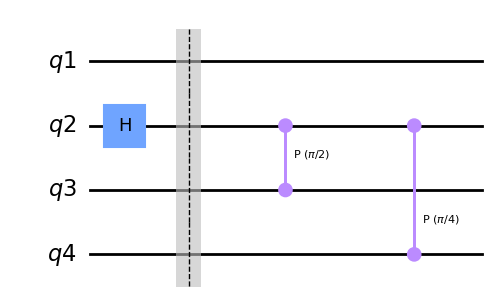

In [7]:
# Choose a 0 < k < n+1
k = 2

# Initialise n qubits, mask the previous k-1 qubits and add the pivot sequence
U_k = Qinit(n) + Qmask("1" * (k - 1) + "*") + U_pivot
# the string "1"*(k-1)+"*" indicates the qubits we want to mask, where '1' indicates a masked qubit,
# and use the wildcard '*' to indicate all remaining qubits are unmasked (i.e. '0')

# Create the circuit using the qiskit backend
circuit_primitive = U_k(backend="qiskit")

# Draw the circuit
circuit_primitive.draw("mpl")

## QFT on $n$ qubits in just a few lines!

In [8]:
# QFT circuit
qft = (
    Qpivot(mapping=Qunitary("h()^0"))
    + Qpivot(
        mapping=Qunitary("cp(x)^01"),
        share_weights=False,
        symbol_fn=lambda x, ns, ne: np.pi * 2 ** (-ne),
    )
    + Qmask("1*")
) * n

# Initialize n qubits and append the QFT circuit
qft_n = Qinit(n) + qft


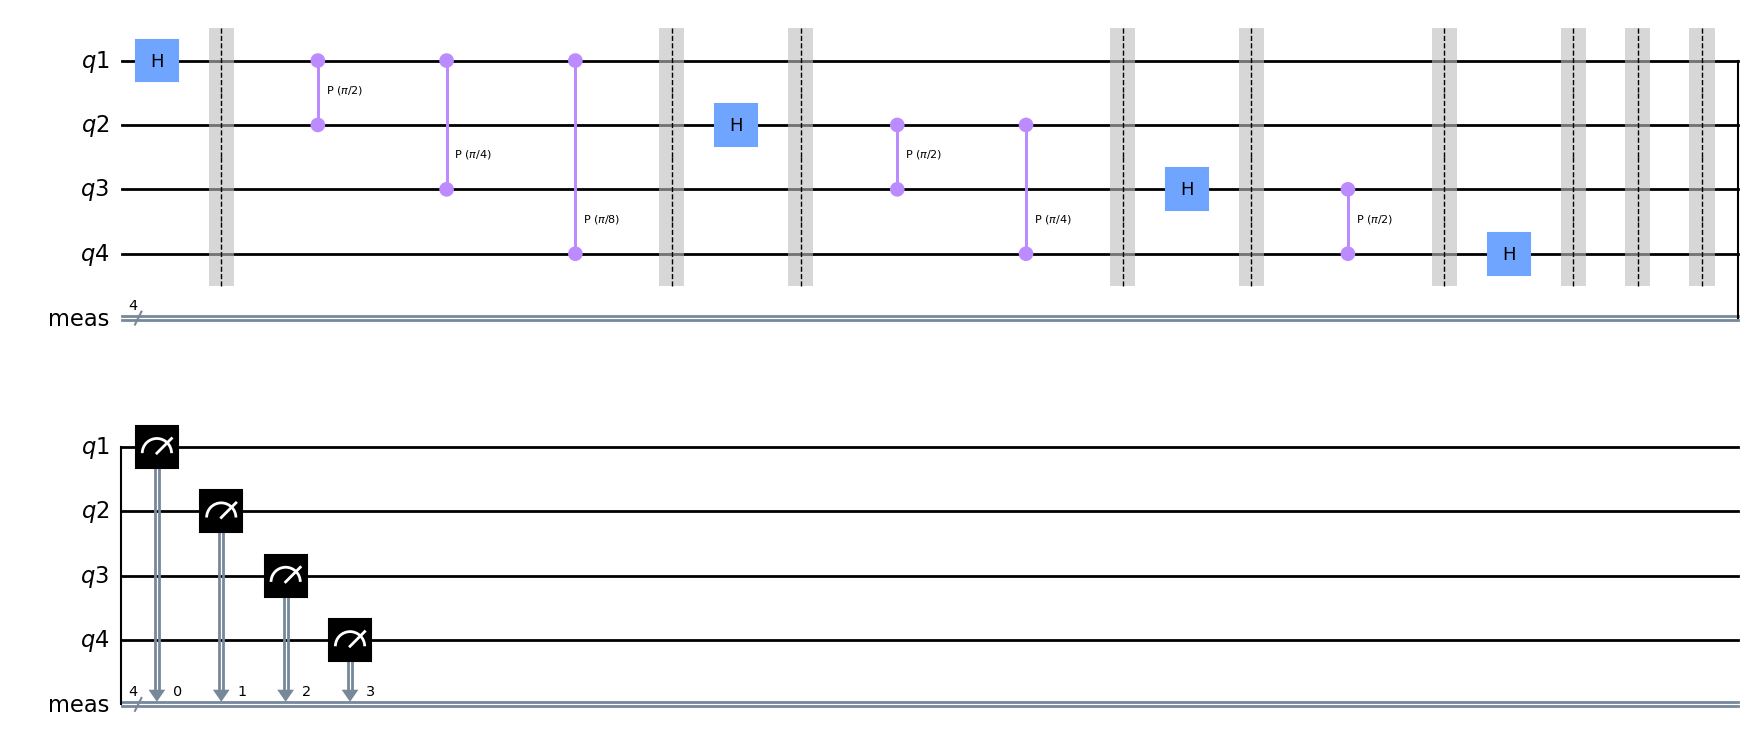

In [9]:
circuit_qft = qft_n(backend="qiskit")
circuit_qft.measure_all()
circuit_qft.draw("mpl")

## Does this perform as intended?

By default the initial state of the circuit is the zero state, that is all qubits in state $|0\rangle$. The state of our $n$ qubits after evolving according to the QFT circuit is
$$\frac{1}{2^{\frac{n}{2}}} (|0\rangle+ e^{2\pi i 0.j_1j_2\dots j_n}|1\rangle) \dots (|0\rangle+ e^{2\pi i 0.j_{n-1}j_n}|1\rangle) (|0\rangle+ e^{2\pi i 0.j_n}|1\rangle )\,.$$ 

You may notice that in fact the order of the qubits is reversed compared to the theoretical QFT given in Equation $(2)$. This can be fixed by performing a series of "swap" operation but for simplicity we can assume that the user is aware of this and that they should in fact read all output bit strings in reverse. Note that Qiskit by default reads outs from the bottom to the top of the circuit, so that this is automatically taken care.

### Run an experiment and plot a histogram of the final counts

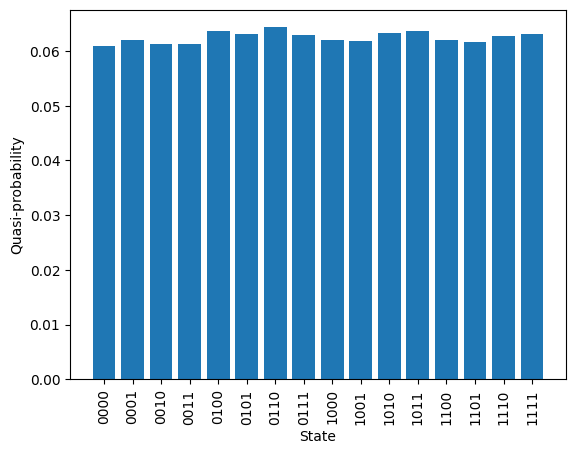

In [10]:
fig, _ = experiment(circuit_qft)
plt.show()

### Compute the theoretical count

For an input vector $\vec{x} = (1,0,0,0,0)$, we can compute the $k$ th element of the transformed vector according to the classical Fourier transform in equation $(1)$
$$y_k = \frac{1}{\sqrt{N}} \sum^{N-1}_{j=0} \delta_{0,j} e^{2\pi ijk/N} = \frac{1}{\sqrt{N}}\,. $$

Here $N = 2^n$ and the probability of measuring the state $|k\rangle$ is $|y_k|^2 = 1/2^n$. We therefore expect to see a uniform distribution across all values $k$ with probability amplitude:


In [11]:
1 / 2**n

0.0625

## Experiments

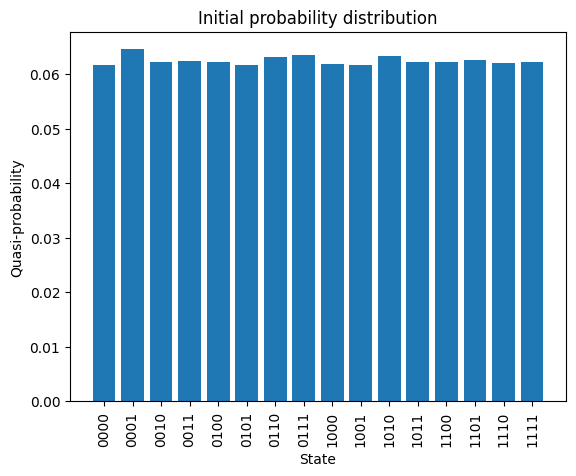

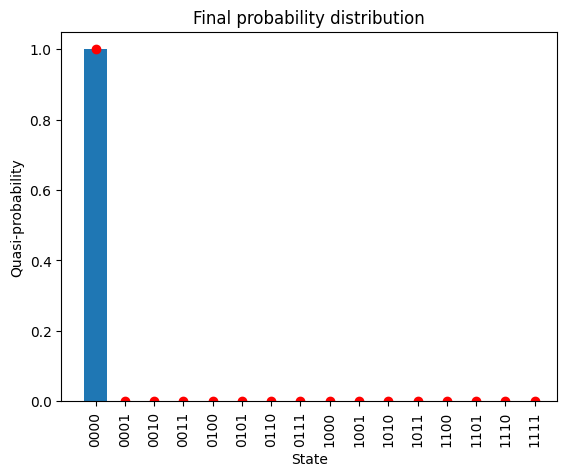

In [12]:
# Take the initial state to be a uniform distribution of all possible states
qft_uniform = Qinit(n) + Qcycle(mapping=h)
circuit_uniform = qft_uniform(backend="qiskit")
circuit_uniform.measure_all()
fig, counts_Initial = experiment(circuit_uniform, seed=42)
plt.title("Initial probability distribution")
plt.show()

# Append the qft circuit
qft_uniform = qft_uniform + qft
circuit_uniform = qft_uniform(backend="qiskit")
circuit_uniform.measure_all()
fig, _ = experiment(circuit_uniform, seed=42)

# Compute the FFT of the initial state for comparison
labels = [bin(k)[2:].zfill(n) for k in range(2**n)]
fft = get_fft(counts_Initial, n)
plt.plot(labels, fft, "or")
plt.title("Final probability distribution")
plt.show()


0010


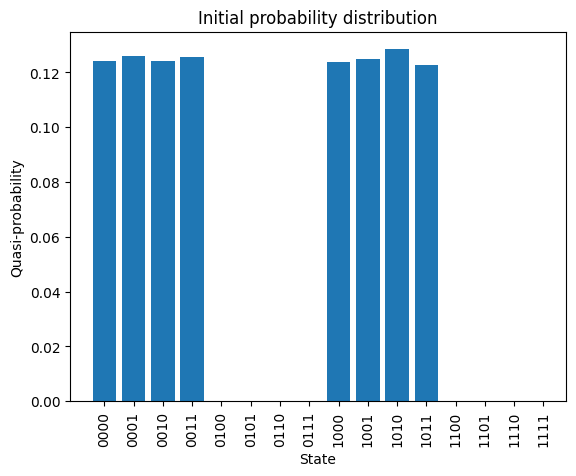

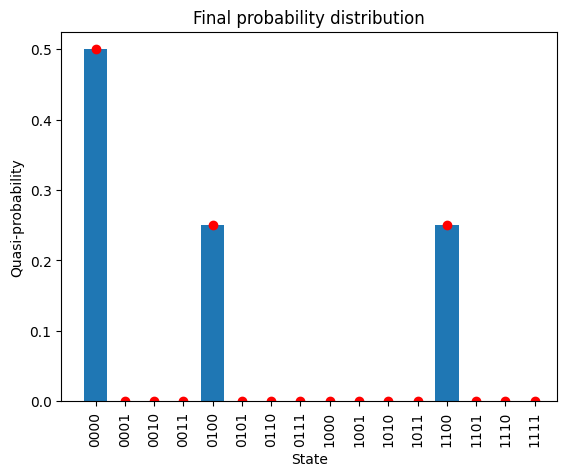

In [66]:
# Generate an initial state by applying Hadamards to a random sample of qubits
# Generate a random number between 0 and 2^n, convert to binary and use as a mask pattern
r = np.random.randint(0, 2**n)
r = bin(r)[2:].zfill(n)
print(r)

qft_nonuniform = Qinit(n) + Qmask(r) + Qcycle(mapping=h) + Qunmask("previous")
circuit = qft_nonuniform(backend="qiskit")
circuit.measure_all()
fig, counts_Initial = experiment(
    circuit,
)
plt.title("Initial probability distribution")
plt.show()

qft_random_Final = qft_nonuniform + qft
circuit = qft_random_Final(backend="qiskit")
circuit.measure_all()
fig, counts_Final = experiment(circuit)

# Compute the FFT of the initial state for comparison
labels = [bin(k)[2:].zfill(n) for k in range(2**n)]
fft = get_fft(counts_Initial, n)
plt.plot(labels, fft, "or")
plt.title("Final probability distribution")
plt.show()